<a href="https://colab.research.google.com/github/times2049/Diffusion-Models-from-scratch-in-Pytorch-for-edu/blob/main/Diffusion_Models_from_scratch_in_Pytorch_for_edu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Diffusion Model from Scratch in Pytorch

최소한의 코드로 디퓨전 모델을 이해해봅시다.
논문과 대응되고, 정확히 구현되는,
데이터셋은 OO입니다.
설명은 최소화합니다.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)
- [A Diffusion Model from Scratch in Pytorch](https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=wLHSIArLcFK0)

## Investigating the dataset
# todo : 이걸 어쩔까... 고민
As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

In [ ]:
import torch
from torchvision.datasets import StanfordCars
import matplotlib.pyplot as plt

def show_images(datset, num_samples=9, cols=3):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(num_samples/cols + 1, cols, i + 1)
        plt.imshow(img[0])

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting stanford_cars/car_devkit.tgz to stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting stanford_cars/cars_train.tgz to stanford_cars


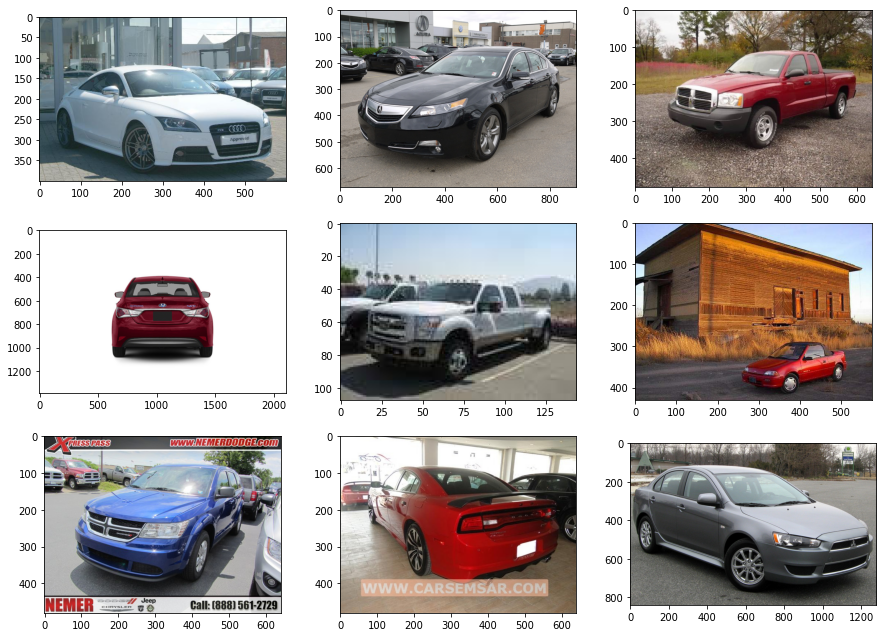

In [ ]:
data = StanfordCars(root=".", download=True)
show_images(data)

# forward diffusion process

#beta schedule

In [ ]:
from torch import linspace
def make_beta_schedule(how_to, T, start=1e-4, end=2e-2): 
  if how_to == "linear":
    betas = (linspace(start, end, T)) #(1e-4, ... , 2e-2)
  elif  how_to == "quad":
    betas = (linspace(start**0.5, end**0.5, T)) ** 2.
  return betas

In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 128
RGB = 3
X_shape = (BATCH_SIZE, RGB, IMG_SIZE, IMG_SIZE)

In [ ]:
from torch import gather
def gather_coef_t(coef, t): 
    """ 
    Returns a specific index t of a passed list of coefficients
    """
    coef_t = gather(coef, -1, t)
    return coef_t[ (...,) + (None,)*3 ] # expand axis

In [ ]:

T = 300 # Total steps
betas = make_beta_schedule('linear', T)

In [ ]:
from torch import cumprod, sqrt, randn

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = cumprod(alphas, axis=0)

# calculations for diffusion q(Xt | X0)
sqrt_alphas_cumprod = sqrt(alphas_cumprod)
sqrt_1_minus_alphas_cumprod  = sqrt(1 - alphas_cumprod) 



In [ ]:
def diffuse(X0, t):
  noise = randn(X_shape)# N(0,I)
  sqrt_alphas_cumprod_t = gather_coef_t(sqrt_alphas_cumprod, t)
  sqrt_1_minus_alphas_cumprod_t = gather_coef_t(sqrt_1_minus_alphas_cumprod, t)
  #reparameterization trick
  Xt = sqrt_alphas_cumprod_t * X0 + sqrt_1_minus_alphas_cumprod_t * noise 
  return Xt, noise

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset

import numpy as np
from torchvision.transforms import Resize, RandomHorizontalFlip \
                                    ,ToTensor, Lambda, Compose

def transform(): # 뭐라 짓지
    return Compose([
                        Resize( (IMG_SIZE,)*2 ), 
                        RandomHorizontalFlip(),
                        ToTensor(), # Scales data into [0,1] 
                        Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
                    ])
def load_datasets(): #todo transfrom 함수 따로

    transforms = transform() #변수 뭐라 써야될까?
     #todo 데이터 바꾸기
    train = StanfordCars(root=".", download=True, 
                                         transform=transforms)

    test = StanfordCars(root=".", download=True, 
                                         transform=transforms, split='test') 
    return ConcatDataset([train, test])



In [ ]:
datasets = load_datasets()
dataloader = DataLoader(datasets, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np

def ScaleBack():
  def scale_back(X):
    X = ( (X + 1) / 2 ) * 255.
    X = X.permute(1,2,0) # CHW to HWC
    return X.numpy().astype(np.uint8) 
  return Lambda(scale_back)

def show_image(image):
    transforms = Compose([ScaleBack(), ToPILImage()])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(transforms(image))



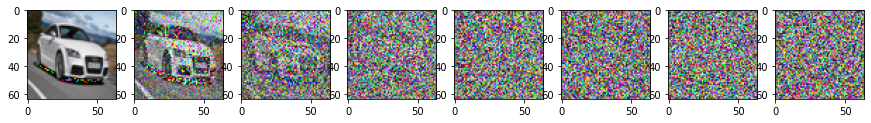

In [ ]:
from torch import tensor, int64

plt.figure(figsize=(15,15)) 
plt.axis('off')
num_images = 7
stepsize = int(T/num_images) 
X0 = next(iter(dataloader)) 

t_batch_size = 1
for t in range(0, T, stepsize):
  t = tensor([t])
  plt.subplot(1, num_images+1, (t/stepsize) + 1)
  
  Xt, _ = diffuse(X0[0], t)
  # todo:이미지 출력
  show_image(Xt)

In [ ]:
from torch.nn import Conv2d, ReLU, BatchNorm2d, Linear, ConvTranspose2d, Module
from torch.nn.functional import relu
class ConvActNorm(Module):
    def __init__(self, in_ch, out_ch):
      super().__init__()
      self.conv = Conv2d(in_ch , out_ch, 3, padding=1)
      self.norm = BatchNorm2d(out_ch)
    def forward(self,x):
      return self.norm(relu(self.conv(x)))

class Block(Module):
    def __init__(self, in_ch, out_ch, t_emb_dim=None, is_up=None):
        super().__init__()
        self.mlp = Linear(t_emb_dim, out_ch)
        in_ch = 2 * in_ch if is_up else in_ch
        Interpolate2d = ConvTranspose2d if is_up else Conv2d

        self.CAN1= ConvActNorm(in_ch, out_ch) 
        self.CAN2 = ConvActNorm(out_ch, out_ch)
        self.Down_or_Up = Interpolate2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x, t):
        h = self.CAN1(x)
        t_embedding = relu(self.mlp(t))
        h += t_embedding[ (..., ) + (None,) * 2 ] 
        h = self.CAN2(h)
        return self.Down_or_Up(h)

In [ ]:
from torch.nn import ModuleList, Sequential
from functools import partial

class Unet(Module):
    def __init__(self, chs = (64, 128, 256, 512, 1024), t_emb_dim = 32):
        super().__init__()
        img_ch = 3
        # Time embedding
        self.embedding= Sequential(
                SinusoidalPositionEmbeddings(t_emb_dim),
                Linear(t_emb_dim, t_emb_dim)
            )
        Down = partial(Block, t_emb_dim=t_emb_dim, is_up=False)
        Up = partial(Block, t_emb_dim=t_emb_dim, is_up=True)
        depth = range(len(chs)-1)
        # Initial projection
        self.init = Conv2d(img_ch, chs[0], 3, padding=1) 
        # Downsample, Upsample
        self.downs = ModuleList([Down(chs[i], chs[i+1]) for i in depth])
        self.ups = ModuleList([Up(chs[i+1], chs[i]) for i in reversed(depth)])
        #out
        self.out = Conv2d(chs[0], img_ch, 1)

    def forward(self, x, t):
        x, t, residuals = self.init(x), relu(self.embedding(t)), []
        # Unet
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)

        for up in self.ups:
          x = cat( [x, residuals.pop()], dim=1 )           
          x = up(x, t)
        return self.out(x)

In [ ]:
from torch import cat, exp, log, arange, tensor
class SinusoidalPositionEmbeddings(Module):   # todo ?
    def __init__(self, t_emb_dim):
        super().__init__()
        self.dim = t_emb_dim

    def forward(self, t):
        half_dim = self.dim // 2
        embeddings = log(tensor([10000])) / (half_dim - 1)
        embeddings = exp(arange(half_dim) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

In [ ]:
from torch.optim import Adam
from torch import cuda, device
lr = 0.001

if cuda.is_available():
  print(cuda.is_available())
  cuda.set_device(device("cuda:0"))


model = Unet()
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
from torch.nn.functional import pad
alphas_cumprod_prev = pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = sqrt(1.0 / alphas)
sqrt_one_minus_alphas_cumprod = sqrt(1. - alphas_cumprod)
# posterior
sqrt_betas_tilde = sqrt(betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod))

#Sampling

In [ ]:
from torch import no_grad
@no_grad()
def sample(Xt, t, model): 
    betas_t = gather_coef_t(betas, t) # 1 - alpha_t
    sqrt_one_minus_alphas_cumprod_t = gather_coef_t(sqrt_one_minus_alphas_cumprod, t)
    sqrt_recip_alphas_t = gather_coef_t(sqrt_recip_alphas, t)
    coef_eps =  betas_t / sqrt_one_minus_alphas_cumprod_t
    noise_predicted = model(Xt, t) 
    
    Xt_prev_mean = sqrt_recip_alphas_t * (Xt - coef_eps * noise_predicted)
    if t != 0:  
        noise = randn(X_shape) 
        sqrt_betas_tilde_t = gather_coef_t(sqrt_betas_tilde, t) #posterior
        return Xt_prev_mean + sqrt_betas_tilde_t * noise  
    else:
        return Xt_prev_mean# ddpm 3.3

 

In [ ]:

@no_grad()
def inference(model, T):
  Xt = randn(X_shape) # XT
  for t in arange(T-1,0,-1):
    Xt_prev = sample(Xt, t[None], model) 
    Xt = Xt_prev 
  X0 = sample(Xt, tensor([0]), model) # 3.3
  return X0

@no_grad()
def show_images_generated(num_images): ## todo 중간 과정을 이미지화 하게 되는?
    # Sample noise
    plt.figure(figsize=(15,15))
    plt.axis('off')
    stepsize = int(T/num_images)

    for i in range(num_images):
        img = inference(model, T)
        if t % stepsize == 0:                          #todo 인퍼런스 함수랑 섞임
            plt.subplot(1, num_images, i+1)
            show_image(img.detach().cpu())
    plt.show()   
show_images_generated(1)

NameError: ignored

In [ ]:
@no_grad()
def show_reverse_process(num_images): ## todo 중간 과정을 이미지화 하게 되는?
    # Sample noise
    Xt = randn(X_shape) # XT
    plt.figure(figsize=(15,15))
    plt.axis('off')
    stepsize = int(T/num_images)

    for t in arange(T-1,0,-1):
        img = sample(Xt, t[None], model)
        if t % stepsize == 0:                          #todo 인퍼런스 함수랑 섞임
            plt.subplot(1, num_images, t/stepsize+1)
            show_image(img.detach().cpu())
    plt.show()     
show_reverse_process(5)

#Training

In [ ]:
from torch import randint
from torch.nn.functional import l1_loss
def trainer(model, optimizer, dataloader):
  for step, (X0,_) in enumerate(dataloader):
    optimizer.zero_grad()
    t = randint(0, T, (BATCH_SIZE,)) 
    Xt, noise = diffuse(X0, t) 
    predicted = model(Xt, t)
    loss = l1_loss(noise, predicted)
    loss.backward()
    optimizer.step()
  return loss,step

In [ ]:

epochs = 100
for epoch in range(epochs):
  loss, step = trainer(model, optimizer, dataloader)
  
  if epoch == 0 and step == 1:
    print(f"Epoch {epoch} | Loss: {loss.item()} ") # test

    show_reverse_process(10)
    break
    
